In [1]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm

import sys
sys.path.append('../functions/')

import plot_params

from matplotlib.colors import LogNorm
from ts_plot import *

import date_conversions as dc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


##### Process L0 Slocum data to L1 and save as NetCDF

In [2]:
# read in the mat file from the Geomar toolbox processed Slocum data and save as netcdf

In [3]:
%run process-slocum-mat-to-nc.py

/Users/xduplm/Library/CloudStorage/GoogleDrive-marceldpl10@gmail.com/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-warming/duplessis-storms-warming/code/processing


100%|██████████| 980/980 [01:12<00:00, 13.50it/s]  


<xarray.Dataset>
Dimensions:      (time: 6979677, profile: 980)
Coordinates:
  * time         (time) float64 7.374e+05 7.374e+05 ... 7.375e+05 7.375e+05
  * profile      (profile) float64 1.0 2.0 3.0 4.0 ... 977.0 978.0 979.0 980.0
Data variables:
    chlorophyll  (time) float64 0.1064 0.4964 0.8863 1.276 ... nan nan nan nan
    latitude     (time) float64 -54.01 -54.01 -54.01 ... -54.01 -54.01 -54.01
    longitude    (time) float64 0.0007786 0.0007764 ... 0.04202 0.04203
    pressure     (time) float64 nan nan nan nan ... -0.1146 -0.1257 -0.1368
    salinity     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    temperature  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dive         (time) float64 0.0 0.0 0.0 0.0 0.0 ... 489.5 489.5 489.5 489.5
    u            (profile) float64 0.148 -0.01497 -0.01499 ... 0.105 0.1258
    v            (profile) float64 0.1515 0.008567 ... -0.08515 -0.06107
Attributes:
    description:  Slocum dataset with raw vari

PermissionError: [Errno 13] Permission denied: b'/Users/xduplm/Library/CloudStorage/GoogleDrive-marceldpl10@gmail.com/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-warming/duplessis-storms-warming/data/slocum/slocum_L1_20240721.nc'

Load the most recent slocum dataset. 

In [3]:
sl = xr.open_dataset('../../../data/slocum/slocum_processed.nc').load()

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/xduplm/Library/CloudStorage/GoogleDrive-marceldpl10@gmail.com/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-warming/duplessis-storms-warming/data/slocum/slocum_L1_20240721.nc'

Original size of the dataset: 6979677

In [4]:
# remove pressure and temeprature values that are below -5 (erroneous data)

variable = ['pressure', 'temperature']

threshold = -5

for v in variable:

    original_size = sl.time.size

    sl = sl.isel(time = sl[v].data > threshold)

    new_size = sl.time.size

    print(v, 'removed', original_size - new_size, 'data points')

pressure removed 4199 data points
temperature removed 287377 data points


Make the date into `datetime64` format

In [5]:
sl['time'] = (('time'), dc.matdate2pydate(sl['time'].data))

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_35004/739887292.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  sl['time'] = (('time'), dc.matdate2pydate(sl['time'].data))
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_35004/739887292.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 

Run through each profile of the slocum dataset and find the minimum depth of that profile. This should be somewhere at the surface.

In [5]:
min_dpt = np.ndarray([np.unique(sl['dive']).size])

for i, d in enumerate(np.unique(sl['dive'].data)):

    min_dpt[i] = sl.isel(time = sl['dive']==d).pressure.min()

In [6]:
min_dpt[~np.isnan(min_dpt)].size

910

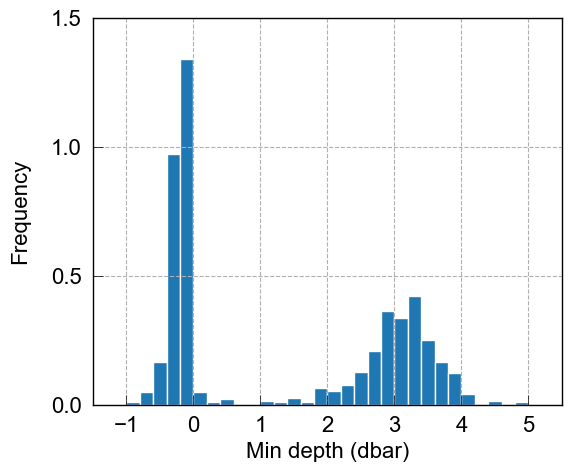

In [7]:
fig,ax=plt.subplots(figsize=(6,5))

ax.hist(min_dpt, bins=np.arange(-5, 5.2, 0.2), density=True, edgecolor='w')

ax.set_xlabel('Min depth (dbar)')

ax.set_ylabel('Frequency', labelpad=15)

ax.set_ylim(0, 1.5)

ax.set_xlim(-1.5, 5.5)

ax.yaxis.set_ticks([0, 0.5, 1, 1.5])

ax.grid(ls='--')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-paper/figs/slocum_processing/depth_min.png', dpi=500)

In [6]:
import gsw

sl['depth'] = (('time'), -gsw.z_from_p(sl['pressure'].data, lat=sl['latitude'].data))

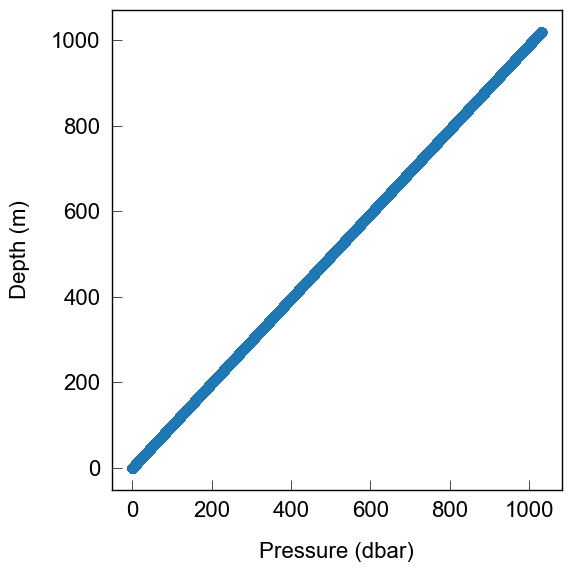

In [9]:
fig,ax=plt.subplots(figsize=(6, 6))

ax.scatter(sl['pressure'], sl['depth'])

ax.set_xlabel('Pressure (dbar)', labelpad=15)
ax.set_ylabel('Depth (m)', labelpad=15)

fig.tight_layout()

#### Now let's choose all the data points above 10 m

In [9]:
condition = sl['depth'] < 10

# Use .where() to create a new xarray object based on the condition
sl_ = sl.isel(time=condition)

#### How many dives remain?

In [10]:
for i in range(1, 11):

    condition = sl['depth'] < i

    sl_ = sl.isel(time=condition)

    print('Profile with data above', str(i),  'm - dives left:', np.unique(sl_.dive).size, 'out of', np.unique(sl.dive).size, '-', np.round(100*np.unique(sl_.dive).size/np.unique(sl.dive).size, 2), '%')
    

Profile with data above 1 m - dives left: 470 out of 910 - 51.65 %
Profile with data above 2 m - dives left: 493 out of 910 - 54.18 %
Profile with data above 3 m - dives left: 651 out of 910 - 71.54 %
Profile with data above 4 m - dives left: 874 out of 910 - 96.04 %
Profile with data above 5 m - dives left: 888 out of 910 - 97.58 %
Profile with data above 6 m - dives left: 906 out of 910 - 99.56 %
Profile with data above 7 m - dives left: 908 out of 910 - 99.78 %
Profile with data above 8 m - dives left: 908 out of 910 - 99.78 %
Profile with data above 9 m - dives left: 908 out of 910 - 99.78 %
Profile with data above 10 m - dives left: 908 out of 910 - 99.78 %


#### What is the vertical resolution?

/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


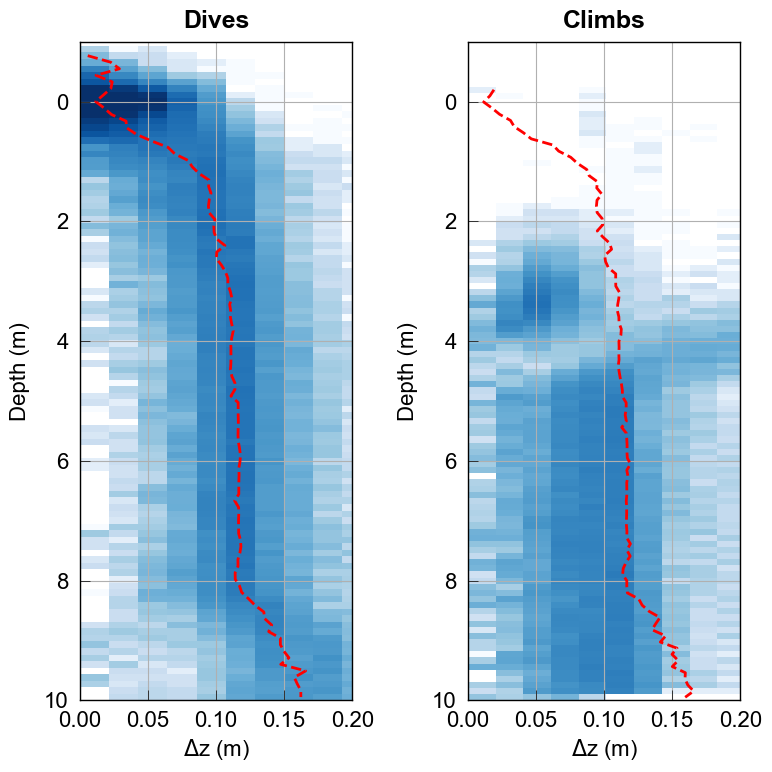

In [68]:
fig,ax=plt.subplots(1, 2, figsize=(8, 8))

sl_dive  = sl_.isel(time=sl_.dive.data % 1 == 0.0) # even -> downcast
sl_climb = sl_.isel(time=sl_.dive.data % 1 == 0.5) # odd -> upcast

x_d = np.abs(sl_dive.depth.diff(dim='time'))
y_d = sl_dive.depth[1:]

x_c = np.abs(sl_climb.depth.diff(dim='time'))
y_c = sl_climb.depth[1:]

h, xedges, yedges, im = ax[0].hist2d(x_d, y_d, bins=(500, 100), cmap='Blues', norm=LogNorm(vmin=1, vmax=1e3))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# # Calculate the mean of x-values for each y bin
mean_x = []
for i in range(len(yedges) - 1):
    y_bin = (yedges[i], yedges[i + 1])
    x_in_bin = x[(y >= y_bin[0]) & (y < y_bin[1])]
    mean_x.append(np.median(x_in_bin))

# Plot the mean line
ax[0].plot(mean_x, (yedges[:-1] + yedges[1:]) / 2, color='red', linestyle='--', linewidth=2)
    
h, xedges, yedges, im = ax[1].hist2d(x_c, y_c, bins=(500, 100), cmap='Blues', norm=LogNorm(vmin=1, vmax=1e3))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# # Calculate the mean of x-values for each y bin
mean_x = []
for i in range(len(yedges) - 1):
    y_bin = (yedges[i], yedges[i + 1])
    x_in_bin = x[(y >= y_bin[0]) & (y < y_bin[1])]
    mean_x.append(np.median(x_in_bin))

# Plot the mean line
ax[1].plot(mean_x, (yedges[:-1] + yedges[1:]) / 2, color='red', linestyle='--', linewidth=2)

for a in ax:
    
    a.set_xlim(0, 0.2)
    a.set_ylim(10, -1)

    a.set_xlabel('$\Delta$z (m)')
    a.set_ylabel('Depth (m)', labelpad=10)
    
    a.grid()

ax[0].set_title('Dives', pad=10, fontweight='bold', fontsize=18)
ax[1].set_title('Climbs', pad=10, fontweight='bold', fontsize=18)

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-paper/figs/slocum_processing/depth_res_hist.png', dpi=500)

#### Temperature anomaly from the mean

In [71]:
for i, d in enumerate(np.unique(sl_.dive.data)):

    fig,ax = plt.subplots(figsize=(5, 8))

    dive = sl_.isel(time=sl_.dive==d)
    
    ax.scatter(dive.temperature - dive.temperature.median(), dive.depth, s=30, c='tab:blue', alpha=0.5, lw=0.5)

    ax.set_ylim(10, -1)
    ax.set_xlim(-0.1, 0.1)
    
    ax.axhline(0, c='k', ls='--', zorder=0)
    ax.axvline(0, c='k', ls='--', zorder=0)
    
    ax.set_title('Temp anomaly from mean of top 1m', pad=15, fontweight='bold', fontsize=16)
    
    ax.set_xlabel('Temperature ($^{\circ}$C)')
    ax.set_ylabel('Depth (m)')
    
    fig.tight_layout()

    if i < 10:
    
        plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-paper/figs/slocum_processing/t_prof/temp_anom_from_mean_1m_00' + str(i) + '.png', dpi=500)

    if ((i > 9) & (i < 100)):
    
        plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-paper/figs/slocum_processing/t_prof/temp_anom_from_mean_1m_0' + str(i) + '.png', dpi=500)

    if i > 100:
    
        plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/duplessis-storms-paper/figs/slocum_processing/t_prof/temp_anom_from_mean_1m_' + str(i) + '.png', dpi=500)

    plt.close()

#### Take the SST as the mean of the top 10 meters

In [21]:
dive

<xarray.Dataset>
Dimensions:      (time: 80, profile: 980)
Coordinates:
  * time         (time) datetime64[ns] 2018-12-13T15:50:13.999000 ... 2018-12...
  * profile      (profile) float64 1.0 2.0 3.0 4.0 ... 977.0 978.0 979.0 980.0
Data variables:
    chlorophyll  (time) float64 61.0 61.0 61.05 61.24 ... 71.0 71.0 71.0 70.71
    latitude     (time) float64 -54.01 -54.01 -54.01 ... -54.01 -54.01 -54.01
    longitude    (time) float64 0.000645 0.000645 ... 0.0007304 0.0007323
    pressure     (time) float64 0.5484 0.6604 0.7723 ... 9.731 9.855 9.979
    salinity     (time) float64 34.01 34.01 34.01 34.01 ... 34.01 34.01 34.01
    temperature  (time) float64 0.6554 0.6553 0.6553 ... 0.6174 0.6083 0.5991
    dive         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    u            (profile) float64 0.148 -0.01497 -0.01499 ... 0.105 0.1258
    v            (profile) float64 0.1515 0.008567 ... -0.08515 -0.06107
    depth        (time) float64 0.5435 0.6545 0.7654 0.8764 ... 9.644 9.767 9.89
Attributes:
    description:  Slocum dataset with raw variables, no processing applied

In [22]:
condition = ((sl_['depth'] < 10) & (sl_['depth'] > 0.5))

# Use .where() to create a new xarray object based on the condition
data = sl_.sel(time=condition)

dive_no = np.array([])
sl_sst_med = np.array([])
sl_sst = np.array([])
num_n = np.array([])
lat = np.array([])
lon = np.array([])
time = np.array([], dtype='datetime64[ns]')

for i, d in enumerate(np.unique(sl_.dive.data)):

    dive = data.isel(time=data.dive==d)

    dive_no    = np.append(dive_no, d)
    sl_sst_med = np.append(sl_sst_med, np.nanmedian(dive.temperature.data))
    num_n      = np.append(num_n, len(dive.temperature.data))
    sl_sst     = np.append(sl_sst, dive.temperature.data[0])
    time       = np.append(time, dive.time.min())
    lon        = np.append(lon, np.nanmedian(dive.longitude.data))
    lat        = np.append(lat, np.nanmedian(dive.latitude.data))


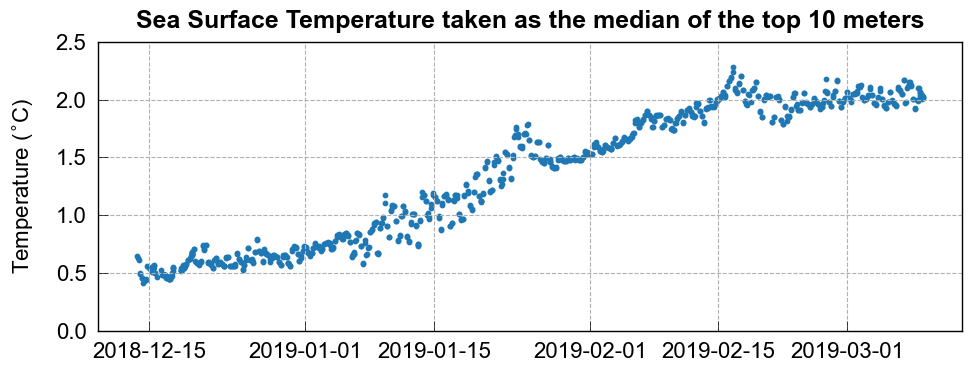

In [13]:
fig,ax = plt.subplots(figsize=(10,4))

ax.scatter(time, sl_sst_med, s=10)

ax.set_ylim(0, 2.5)

ax.grid(ls='--')

ax.set_ylabel('Temperature ($^{\circ}$C)', labelpad=15)

ax.set_title('Sea Surface Temperature taken as the median of the top 10 meters', pad=10, fontweight='bold', fontsize=18)

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/slocum_processing/sst_raw.png', dpi=500)

#### Time resolution minutes

In [14]:
time_res_min = (np.diff(time)/1e9)/60

time_res_min = time_res_min.astype('float64')

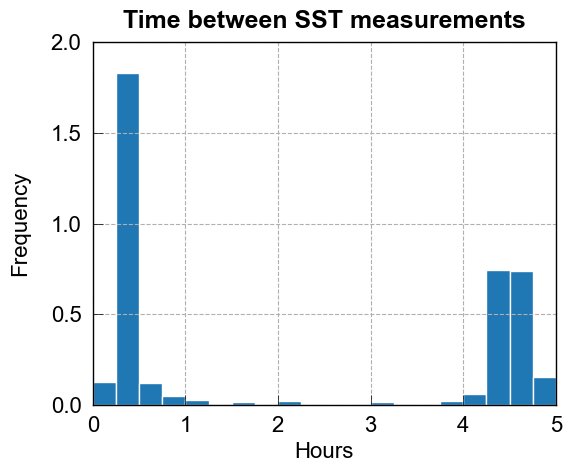

In [15]:
fig,ax=plt.subplots(figsize=(6,5))

ax.hist(time_res_min/60, bins=np.arange(0, 8, 0.25), density=True, edgecolor='w', lw=1)

ax.set_title('Time between SST measurements', pad=10, fontweight='bold', fontsize=18)

ax.set_xlabel('Hours')

ax.set_ylabel('Frequency', labelpad=15)

ax.set_ylim(0, 2)

ax.set_xlim(0, 5)

ax.yaxis.set_ticks(np.arange(0, 2.5, 0.5))

ax.grid(ls='--')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/slocum_processing/time_res_hour.png', dpi=500)

#### Grid the data to 6 hour intervals

In [26]:
# Create a dataset with the given variables

sst = xr.Dataset({
                  'dive_no': ('time', dive_no),
                  'sst': ('time', sl_sst_med),
                  'num_n': ('time', num_n), 'lat': ('time', lat), 'lon': ('time', lon)
              }, coords={'time': time})

# Print the resulting xarray dataset
print(sst)

sst.to_netcdf('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_sst_mean_10m_20231110.nc')

<xarray.Dataset>
Dimensions:  (time: 908)
Coordinates:
  * time     (time) datetime64[ns] 2018-12-13T15:50:13.999000 ... 2019-03-09T...
Data variables:
    dive_no  (time) float64 0.0 0.5 1.0 1.5 2.0 ... 488.0 488.5 489.0 489.5
    sst      (time) float64 0.6492 0.6312 0.6173 0.4961 ... 2.02 2.019 2.02
    num_n    (time) float64 80.0 46.0 88.0 38.0 74.0 ... 88.0 38.0 77.0 43.0
    lat      (time) float64 -54.01 -53.99 -53.99 -53.97 ... -54.01 -54.01 -54.01
    lon      (time) float64 0.0006702 0.03927 0.03726 ... 0.04158 0.04114


Take a mean of the 6H and 1D slocum SST

In [47]:
sst_6h = sst.resample(time='6H').mean()
sst_1d = sst.resample(time='1D').mean()

In [49]:
series = pd.Series(sst_6h.sst) 

window_size = 4

sst_rm = series.rolling(window=window_size, min_periods=1).mean()

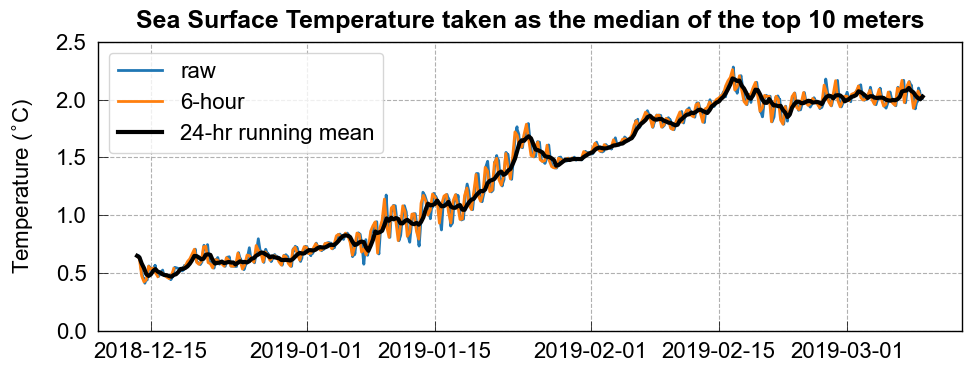

In [52]:
fig,ax = plt.subplots(figsize=(10,4))

ax.plot(sst.time, sst.sst, lw=2, label='raw')
ax.plot(sst_6h.time, sst_6h.sst, lw=2, label='6-hour')

ax.plot(sst_6h.time, sst_rm, lw=3, c='k', label='24-hr running mean')

ax.set_ylim(0, 2.5)

ax.grid(ls='--')

ax.set_ylabel('Temperature ($^{\circ}$C)', labelpad=15)

ax.set_title('Sea Surface Temperature taken as the median of the top 10 meters', pad=10, fontweight='bold', fontsize=18)

ax.legend()

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/slocum_processing/sst_raw_gridded.png', dpi=500)

In [29]:
sl.to_netcdf('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_L2_20231110.nc')

In [31]:
sl

<xarray.Dataset>
Dimensions:      (time: 6688101, profile: 980)
Coordinates:
  * time         (time) datetime64[ns] 2018-12-13T15:47:26.999000 ... 2019-03...
  * profile      (profile) float64 1.0 2.0 3.0 4.0 ... 977.0 978.0 979.0 980.0
Data variables:
    chlorophyll  (time) float64 63.9 64.3 64.7 64.7 ... 96.0 95.85 95.65 95.45
    latitude     (time) float64 -54.01 -54.01 -54.01 ... -54.01 -54.01 -54.01
    longitude    (time) float64 0.0005075 0.0005077 0.000507 ... 0.0411 0.0411
    pressure     (time) float64 0.06628 0.07172 0.07755 ... 0.8246 0.6859 0.5383
    salinity     (time) float64 34.01 34.01 34.01 34.01 ... 33.86 33.86 33.86
    temperature  (time) float64 0.6529 0.653 0.6531 0.6532 ... 2.03 2.03 2.03
    dive         (time) float64 0.0 0.0 0.0 0.0 0.0 ... 489.5 489.5 489.5 489.5
    u            (profile) float64 0.148 -0.01497 -0.01499 ... 0.105 0.1258
    v            (profile) float64 0.1515 0.008567 ... -0.08515 -0.06107
    depth        (time) float64 0.06568 0.07108 0.07686 ... 0.8172 0.6798 0.5335
Attributes:
    description:  Slocum dataset with raw variables, no processing applied